<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 6th exercise: <font color="#C70039">Work with Autoencoders for anomaly detection</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   08.08.2023

<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" style="float: center;" width="700">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
Autoencoder is an unsupervised artificial neural network (ANN) that learns how to efficiently compress and encode data and then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

An Autoencoder reduces data dimensions by learning how to ignore the noise in the data and thus outliers.
In the section above, you can seen an example of the input/output image from the MNIST dataset to an Autoencoder.

#### Autoencoder Components:
An Autoencoder consists of four main parts:

1. Encoder: In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.

2. Bottleneck: which is the layer that contains the compressed representation of the input data. This is the lowest possible dimensions of the input data. The bottlneck is also called latent vector. The concept of the latent space and latent vectors becomes important later on as we move forward to understand Generative Models. 

3. Decoder: In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.

4. Reconstruction Loss: This is the method that measures how well the decoder is performing and how close the output is to the original input.

As always in ANNs, the training itself involves back propagation in order to minimize the network’s reconstruction loss.

Due to this features of an Autoencoder the use cases are manyfold. One of the obviously is anomaly detection. 

#### Autoencoder Architecture:

The network architecture for Autoencoders can vary between simple Feed Forward networks, Recurrent Neural Networks (LSTM) or Convolutional Neural Networks (CNN) depending on the use case. 

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * the example below shows how to use an autoencoder for anomaly detection

4. <font color=green>Develop an Autoencoder for Domain Adaptation (Me -> Walter White ). You can of course also take own data, e.g. a photo of yours and someone else.</font>
5. Set at least the following hyperparameters for training (epochs=100000, shuffle=True).
6. Implement a CNN for working out important features for the adaptation. If you feel lost in the exercise, please visit the sample solution.
7. There is also an implementation of data augmentation that helps you building up your data set from one single "original" image. 
---------------------------------

### Auto-Encoding
If you have correlated input data, the auto-encoder method will work very well because the encoding operation relies on the correlated features to compress the data.
Let’s consider that an auto-encoder is trained on the MNIST dataset. 
As you know already, using a simple FeedForward neural network, this can be done by building a simple 6 layers network as below:

Epoch 1/10
59/59 [==============================] - 9s 99ms/step - loss: 0.0734 - val_loss: 0.0482
Epoch 2/10
59/59 [==============================] - 5s 91ms/step - loss: 0.0407 - val_loss: 0.0341
Epoch 3/10
59/59 [==============================] - 5s 90ms/step - loss: 0.0315 - val_loss: 0.0283
Epoch 4/10
59/59 [==============================] - 5s 85ms/step - loss: 0.0272 - val_loss: 0.0253
Epoch 5/10
59/59 [==============================] - 5s 86ms/step - loss: 0.0248 - val_loss: 0.0234
Epoch 6/10
59/59 [==============================] - 5s 90ms/step - loss: 0.0232 - val_loss: 0.0221
Epoch 7/10
59/59 [==============================] - 5s 88ms/step - loss: 0.0220 - val_loss: 0.0210
Epoch 8/10
59/59 [==============================] - 5s 84ms/step - loss: 0.0210 - val_loss: 0.0201
Epoch 9/10
59/59 [==============================] - 7s 117ms/step - loss: 0.0202 - val_loss: 0.0194
Epoch 10/10
1/1 [==============================] - 1s 749ms/step


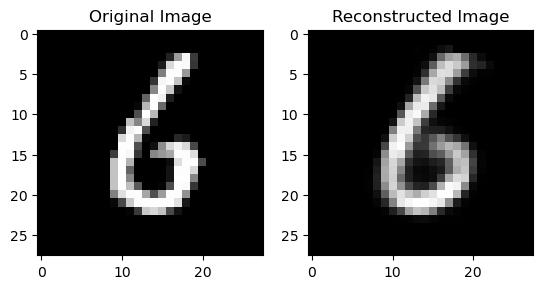

In [5]:
import numpy as np
import keras
from   keras.datasets import mnist
from   keras.models import Sequential, Model
from   keras.layers import Dense, Input
from   keras import optimizers
from   keras.optimizers import Adam

# load the inbuild mnist data set (8bit grayscale digits)
# https://en.wikipedia.org/wiki/MNIST_database
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# normalize the training and the validation data set
train_x = x_train.reshape(60000, 784) / 255
val_x = x_test.reshape(10000, 784) / 255

# build the auto-encoding layers
autoencoder = Sequential()
autoencoder.add(Dense(512,  activation='elu', input_shape=(784,)))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(10,   activation='linear', name="bottleneck"))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(512,  activation='elu'))
autoencoder.add(Dense(784,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

'''
NOTE:
-----
The Exponential Linear Unit (ELU) is an activation function for neural networks. 
In contrast to ReLUs (which you know), ELUs have negative values which allows them to push mean unit 
activations closer to zero like batch normalization but with lower computational complexity.
'''    

# train the model and finally assign the encoding to the decoder
'''
NOTE:
-----
make sure you understand, that you are training on train_x and not on train_y but train_x again for the reconstruction
the same for the validation (val_x, val_x)
'''
trained_model = autoencoder.fit(train_x, train_x, batch_size=1024, epochs=10, verbose=1, validation_data=(val_x, val_x))
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

encoded_data = encoder.predict(train_x)  # bottleneck representation


encoding_dim = 10

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

import matplotlib.pyplot as plt

# take an image from the validation data set or the training data set, respectively
input_img = val_x[50] 
input_img_2d = input_img.reshape(28, 28)

decoded_output = autoencoder.predict(val_x[50].reshape(1, 784))        # reconstruction

# reshape the output to the original image dimensions
decoded_output = decoded_output.reshape(28,28)

# plot the original and the reconstructed image
plt.subplot(1, 2, 1)
plt.imshow(input_img_2d, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(decoded_output, cmap='gray')
plt.title('Reconstructed Image')
plt.show()


As you can see in the output, the last reconstruction loss/error for the validation set is approx. 0.0197, which is great. 
Now, if we pass any normal image from the MNIST dataset, the reconstruction loss will be very low (< 0.02) BUT if we tried to pass any other different image (outlier / anomaly), we will get a high reconstruction loss value because the network failed to reconstruct the image/input that is considered an anomaly.

Notice in the code above, you can use only the encoder part to compress some data or images and you can also only use the decoder part to decompress the data by loading the decoder layers.

#### Auto-Encoders for Anomaly Detection
Now, let’s do some anomaly detection. The code below uses two different images to predict the anomaly score (reconstruction error) using the autoencoder network we trained above. 

The first image is from the MNIST and the result is error=2.46241018. This means that the image is not an anomaly. The second image (yoda.png) obviously does not belong to the training dataset and the result is: error=2727.0718. This high error means that the image is an anomaly. Even the third image. The same concept applies to any type of dataset.

In [6]:
# If you are using a newer version of keras than '2.4.3', read this article below.
# It describes a versioning issue in the keras libs
'''https://stackoverflow.com/questions/72383347/how-to-fix-it-attributeerror-module-keras-preprocessing-image-has-no-attribu'''
from keras.preprocessing import image

# take an image from the validation data set or the training data set, respectively
input_img = val_x[50] 
input_img_flat = input_img.reshape(1,784)

target_data = autoencoder.predict(input_img_flat)

dist = np.linalg.norm(input_img_flat - target_data, axis=-1)

print(dist)

1/1 [==============================] - 0s 113ms/step
[2.76267517]


In [7]:
from keras.preprocessing.image import load_img, img_to_array
# Now take Master Yoda as the test image. The error score will be very high (error=2727.0718)
img = load_img("./data/yoda.png", target_size=(28, 28), color_mode = "grayscale")
input_img = img_to_array(img)

input_img_flat = input_img.reshape(1,784)
target_data = autoencoder.predict(input_img_flat)
dist = np.linalg.norm(input_img_flat - target_data, axis=-1)
print(dist)

1/1 [==============================] - 0s 100ms/step
[2727.1252]


In [8]:
''' 
Now take a Mnist image which is taken from the google image search and although it is super similar to the training data
it does not belong to the same data distribution the auto-encoder was trained on. 
It produces an error almost as high as yoda.png (approx error=2551.99)
This makes autoencoders being a very robust technique for anomaly detection.
'''
img = load_img("./data/similarMnistNumber.jpg", target_size=(28, 28), color_mode = "grayscale")
input_img = img_to_array(img)

input_img_flat = input_img.reshape(1,784)
target_data = autoencoder.predict(input_img_flat)
dist = np.linalg.norm(input_img_flat - target_data, axis=-1)

print(dist)

1/1 [==============================] - 0s 112ms/step
[2551.8367]


Epoch 1/1000
4/4 [==============================] - 14s 948ms/step - loss: 0.6869 - val_loss: 0.7073
Epoch 2/1000
4/4 [==============================] - 3s 709ms/step - loss: 0.6546 - val_loss: 0.7589
Epoch 3/1000
4/4 [==============================] - 3s 682ms/step - loss: 0.6254 - val_loss: 0.7116
Epoch 4/1000
4/4 [==============================] - 3s 684ms/step - loss: 0.6041 - val_loss: 0.7173
Epoch 5/1000
4/4 [==============================] - 3s 692ms/step - loss: 0.5635 - val_loss: 0.6437
Epoch 6/1000
4/4 [==============================] - 3s 667ms/step - loss: 0.5195 - val_loss: 0.6026
Epoch 7/1000
4/4 [==============================] - 3s 658ms/step - loss: 0.5081 - val_loss: 0.5806
Epoch 8/1000
4/4 [==============================] - 3s 674ms/step - loss: 0.5068 - val_loss: 0.5877
Epoch 9/1000
4/4 [==============================] - 3s 669ms/step - loss: 0.4989 - val_loss: 0.5870
Epoch 10/1000
4/4 [==============================] - 3s 697ms/step - loss: 0.4960 - val_loss: 0.568

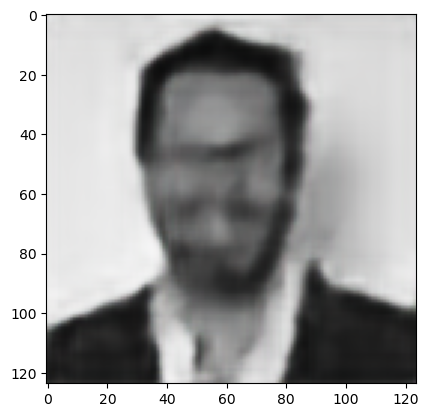

In [9]:
# Import the required libraries and modules
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
import matplotlib.pyplot as plt

# Load the training data from the given directories
gernot_path = './data/heisenberg_heisenberg/gernot'
walter_path = './data/heisenberg_heisenberg/walter'

gernot_images = []
walter_images = []

for filename in os.listdir(gernot_path):
    img = load_img(os.path.join(gernot_path, filename), target_size=(124, 124))
    img = img_to_array(img)
    gernot_images.append(img)

for filename in os.listdir(walter_path):
    img = load_img(os.path.join(walter_path, filename), target_size=(124, 124))
    img = img_to_array(img)
    walter_images.append(img)

# Preprocess the training data
gernot_images = np.array(gernot_images) / 255
walter_images = np.array(walter_images) / 255

# Build the autoencoder model
input_img = Input(shape=(124, 124, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder model on the training data
autoencoder.fit(gernot_images, gernot_images,
                epochs=1000,
                batch_size=16,
                shuffle=True,
                validation_data=(walter_images, walter_images))

# Load the image to be converted
img = load_img('./data/heisenberg_heisenberg/gernot-heisenberg-original.jpg', target_size=(124, 124))
img = img_to_array(img)

# Preprocess the image
img = img / 255
img = np.expand_dims(img, axis=0)

# Use the trained autoencoder model to encode and decode the image
converted_img = autoencoder.predict(img)

# Save the converted image
plt.imshow(converted_img[0])
plt.savefig('./data/heisenberg_heisenberg/gernot-heisenberg-walterized.jpg')
